# Résolution numérique de l’équation de Black-Scholes  par différence finie

BEN MOHAMED Oualid <br>



# Introduction
Le but de ce projet est d’étudier l’équation est de résoudre Black-Scholes, en utilisant l'équation de la chaleur, pour modéliser la valeur d’un call européen. On commencera en définissant Black-Scholes. Dans un second temps, on exécutera les changements de variables pour passer de Black-Scholes à l’équation de la chaleur afin de calculer la solution exacte. Finalement on implémentera l'équation de la chaleur, celle-ci peut être résolue en utilisant trois différents schémas: Euler Explicite, Euler Implicite et Crank-Nicolson. Ces schémas seront définis, implémentés, analysés et comparés.

Librairies nécessaire pour ce projet:

In [ ]:
import numpy as np

import time

from scipy.stats import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Vous reconnaitrez certainement la librarie $"time"$ qui nous sera utile pour l'analyse et la comparaison des différents schémas concernant la rapidité de calcul. Ou encore, la librairie $"matplotlib"$ pour tracer des graphes nous permettant de schématiser nos résultats. 

## 1) Passage de Black-Scholes à l'équation de la Chaleur




### 1.1 Black-Scholes
La formule de Black-Scholes est utilisée pour calculer la valeur d’une option européenne en fonction du temps et de la valeur de l’action sous-jacente.

L'équation est la suivante:

$$\frac{\partial V}{\partial t }+ \frac{\sigma^2 S^2}{2} \frac{\partial^2 V}{2 \partial^2 S} + S.r. \frac{\partial V}{\partial S} - rV = 0  $$  

$V$: le prix de l’option d'un call européen  , on posera C=V, ce qu’on cherche à approcher <br>
$S$ : prix du sous-jacent <br>
$t$ : temps  <br>
$r$ : taux sans risque <br>
$\sigma$ : volatilité du prix de l’action <br>
$K$ : prix d’exercice fixé par l’option <br>



In [ ]:
T = 1   #Maturité
K = 100       # Strike
r = 0.01        # Rendement
sigma = 0.1    # Volatilité      

### 1.2 Conditions initiales

A la maturité $T$: $C(T,S) = max(S-K,0) $ <br>
<br>
Limite en 0:  $C(t,0) = max(S-K,0) $ <br> <br>
Limite en $+\infty$: $C(t,\infty) = max(S-K,0) $

### 1.3 Changements de variables

- $S = Ke^x $ 

- $ t = T - \frac{\tau}{0.5 \sigma^2} $ 

- $ u = K\exp(\alpha x + \beta \tau ) u \ $ . 

- $ k = \frac{r}{0.5 \sigma^2 } $ 

- $\alpha = \frac{-(k-1)}{2} $ 

- $ \beta = \alpha^2 +(k-1)\alpha - k $ 


In [ ]:
#Changements de variable
def t(tau):
    return(T - 2*tau/(sigma**2))    

def S(x):
    return(K*np.exp(x))

k = 2*r/(sigma**2)
alpha = -(k-1)/2
beta = (alpha**2) + (k-1)*alpha - k

#Pay-off
def u_to_call(u,M,N,x,tau):
    V=np.zeros((M+1,2*N+1)) 
    for i in range(0,M+1):
        for j in range(0,2*N+1):
            V[i,j] = K * np.exp(alpha * x[j] + beta * tau[i]) * u[i,j]
    return(V)

### 1.4) Equation de la chaleur
Après tous ces changements de variables on tombe sur l'équation de la chaleur suivante:
$$\frac{\partial u}{\partial \tau}=\frac{\partial^2 u }{\partial^2 x } $$ 

Avec condition initiale:
$$ u(0,x) = u_0(x) = max(\exp(\frac{k+1}{2}x) - \exp(\frac{k-1}{2}x) , 0  ) $$

Et de solution **analytique**:
$$u(\tau , x ) = \frac{1}{2\sqrt{\pi \tau}} \int_{- \infty}^{+\infty} u_0(y) \exp(\frac{-(x-y)^2}{4\tau}) d\tau $$ 

### 1.5) Discrétisation

Pour résoudre l'équation nous devons discrétiser le domaine.

Le prix d'une option dépend de deux paramètres: le temps $t$ et le sous-jacent $S_t$ que nous noterons $x$ par simplification. 

<br>

1.5.1) Discretisation en temps:

En temps, $[0,\frac{1}{2 \sigma^2 }]$ est remplacé par $ [τ0, τ1, . . . , τM]$ ($M$ étant le nombre de points choisis) avec:



*  $\Delta\tau = \frac{\tau_M - \tau_0}{M} $ le pas de temps
* $τ_i = i \Delta\tau , 0 ≤ i ≤ M$ 
* $M \Delta\tau =\frac{1}{2 \sigma^2 }$



<br>

1.5.2) Discretisation en espace:

On choisit un nombre de points $N$, ainsi notre domaine sera :

*   $[-N\Delta x ; N \Delta x ]$ , avec $x_j = j\Delta x $ 
*   $\Delta x = \frac{|x_{sup} - x_{inf} | }{2N} $ 


In [ ]:
def discretisation(M,N):
    xinf = -1
    xsup = 1
    dx = abs(xsup - xinf)/(2*N)     # Pas en espace
    x = np.arange(xinf,xsup+dx,dx) 


    tau0 = 0
    tauT = (sigma**2)*T/2     
    dtau = (tauT - tau0)/M     # Pas en temps
    tau = np.arange(tau0,tauT+dtau,dtau)

    return x,tau,dx,dtau
         
M = 101     
N = 100 
x,tau,dx,dtau = discretisation(M,N)

## 1) Passage de solution équation de la Chaleur à solution BS
On connait donc la solution exacte de l'équation de la chaleur:

$$u(\tau , x ) = \frac{1}{2\sqrt{\pi \tau}} \int_{- \infty}^{+\infty} u_0(y) \exp(\frac{-(x-y)^2}{4\tau}) d\tau $$ 

Avec des changements de variables inverses, on obtient la solution de Black Scholes pour un call européen :

$$C(t,S) = S\mathcal{N}(d_1) - Ke^{-r(T-t)}\mathcal{N}(d_2) $$ 

où : 

$$ d_1 = \frac{\ln(\frac{S}{K}) + ( r+\frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{(T-t)}} $$ 

$$ d_2 = \frac{\ln(\frac{S}{K}) + ( r-\frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{(T-t)}} $$ 

$$ \mathcal{N}(d) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^d e^{-\frac{s^2}{2}} ds = P(\mathcal{N}(0,1) \leq d )  $$ 


In [ ]:
#Implementation Solution Black Scholes
def exact_sol_call(M,N,tau,x):
  u=np.zeros((M+1,2*N+1))  
  for j in range(0,2*N+1):
    Sj = S(x[j]) 
    for i in range(0,M+1):            
      temps = t(tau[i])
      if(temps == T) :
        u[i,j] = max(Sj - K, 0)       
      else :
        d1 = (np.log(Sj/K) + (r + 0.5*sigma**2)*(T - temps))/(sigma *np.sqrt(T - temps))
        d2 = (np.log(Sj/K) + (r - 0.5*sigma**2)*(T - temps))/(sigma *np.sqrt(T - temps))
        u[i,j] = Sj*norm.cdf(d1) - K*np.exp(-r*(T-temps))*norm.cdf(d2)
  return(u)

In [ ]:
t_0 = time.time()
u_exact = exact_sol_call(M,N,tau,x)
t_1 = time.time()
t=t_1-t_0
print("Temps d'exécution de la solution exacte:",t)

Temps d'exécution de la solution exacte: 4.332123756408691


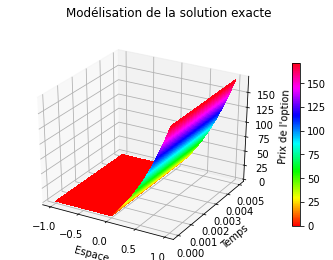

In [ ]:
# plot 3D : 
X0,TAU0 = np.meshgrid(x,tau)
fig0 = plt.figure()
ax0 = fig0.gca(projection = '3d')
surf0 = ax0.plot_surface(X0,TAU0,u_exact, rstride=1, cstride=1, cmap='hsv', linewidth=0, antialiased=False)
fig0.colorbar(surf0, shrink=0.75, aspect=20)
fig0.suptitle("Modélisation de la solution exacte")
ax0.set_xlabel("Espace")
ax0.set_ylabel("Temps")
ax0.set_zlabel("Prix de l'option")
plt.show()

# 2) Schémas aux différences finies

Si on se place à un instant $τ$ donné, et si on suppose qu’on connait la solution $u(x, τ )$, on souhaite calculer la dérivée temporelle $\frac{\ ∂u(x, τ )}{∂τ} $. <br>

Supposons que la solution soit connue aux instants $τ − \Delta\tau$ et $τ + \Delta\tau$ . Il existe alors plusieurs schémas aux
différences finies pour approcher la valeur de la dérivée temporelle.

## Schéma Euler Explicite



Une première approximation de la dérivée partielle de u est donnée par la formule des différences finies décentrée à droite :

$$\frac{u^j_{i+1} - u^j_{i}}{\Delta \tau} = \frac{u^{j+1}_{i} - 2*u^j_{i} + u^{j-1}_{i}}{\Delta x^2}  $$

 $$ \iff u^j_{i+1} = u^j_{i} + \frac{\Delta \tau}{\Delta x}(u^{j+1}_{i} - 2*u^j_{i} + u^{j-1}_{i})$$


<br>
Il est précis d'ordre 1 en temps et d'ordre 2 en espace. 

<br>
C'est un schéma stable si et seulement si $ \gamma=\frac{\Delta \tau}{\Delta x} < \frac{1}{2} $ 


In [ ]:
gamma = dtau/dx**2  # Condition de stabilité : gamma doit être inférieur à 1/2 

Conditions initiales pour Euler Explicite:

- $u^j_0 = u_0(j \Delta x )  ;\qquad \forall -N\leq j \leq N $ 
- $u^{-N}_i = 0 \; ;\qquad   \forall \;  0 \leq i \leq M $ 
- $u^N_i = (e^{x_N} - e^{-r(T-\tau_i)}). e^{-\alpha. x_N - \beta. t_i } ;\qquad  \forall \;  0 \leq i \leq M $ 

In [ ]:
def u_0_call(x): #condition initiale pour un call
  return(max(np.exp(((k+1)/2) * x) - np.exp(((k-1)/2) * x) , 0))

In [ ]:
def euler_explicite(gamma,M,N,x,tau):
    u = np.zeros((M+1,2*N+1))

#Conditions initiales pour un call 
    for j in range(0,2*N+1):
        u[0,j] = u_0_call(x[j])
    u[1:M+1,0] = 0 

    for j in range(1,M+1):
        u[j,2*N] = (np.exp(x[2*N]) - np.exp(-r*(T-tau[j]))) * np.exp(-alpha * x[2*N] - beta * tau[j])
    for j in range(1,M+1):
        u[j,1:2*N] = (1-2*gamma)*u[j-1,1:2*N]+gamma*(u[j-1,0:2*N-1] + u[j-1,2:2*N+1])
    return(u)

In [ ]:
t_exp_0 = time.time()
u_exp = euler_explicite(gamma,M,N,x,tau)
call_exp = u_to_call(u_exp,M,N,x,tau)
t_exp_1 = time.time()
T_Execution_Euler_explicite=t_exp_1-t_exp_0 
print("temps d'exécution d'Euler Explicite=",T_Execution_Euler_explicite)


temps d'exécution d'Euler Explicite= 0.06654930114746094


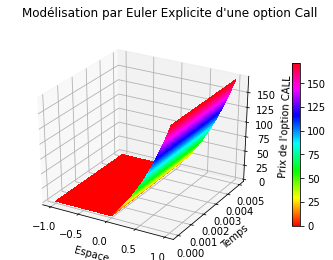

In [ ]:
# plot 3D : 
X,TAU = np.meshgrid(x,tau)
fig = plt.figure()
ax = fig.gca(projection = '3d')
surf = ax.plot_surface(X,TAU,call_exp, rstride=1, cstride=1, cmap='hsv', linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.75, aspect=20)
fig.suptitle("Modélisation par Euler Explicite d'une option Call")
ax.set_xlabel("Espace")
ax.set_ylabel("Temps")
ax.set_zlabel("Prix de l'option CALL")
plt.show()

On obtient un graphique très similaire à celui de la solution exacte, le schéma converge. De plus, les valeurs sont cohérentes: 

-Quand le prix S du sous-jacent  (abscisse "espace") augmente le prix de de l'option augmente.

-Quand le prix S tend vers 0  (abscisse "espace") le prix tend vers 0.

on en déduit que notre schéma Euler Explicite marche.

##Euler Implicite

Une deuxième approximation de la dérivée partielle de u est donneé par la formule des différences finies décentrées à gauche :

$$\frac{u^j_{i} - u^j_{i-1}}{\Delta \tau} = \frac{u^{j+1}_{i} - 2*u^j_{i} + u^{j-1}_{i}}{\Delta x^2}  $$

 $$ \iff u^j_{i-1} = -\frac{\Delta \tau}{\Delta x} u^{j-1}_{i} + (1 + 2\frac{\Delta \tau}{\Delta x})u^j_{i} - \frac{\Delta \tau}{\Delta x}u^{j+1}_{i}$$

$$ \iff u^j_{i-1} = -\gamma u^{j-1}_{i} + (1 + 2\gamma)u^j_{i} - \gamma u^{j+1}_{i}$$

$$ \iff AU_i = U_{i-1} + \gamma b_i  $$ où $b_i = [ u_i^{-N} 0 \cdots 0 u_i^{N} ]^T$  représente les conditions aux bords, et $U_i$ étant la seul inconnue.

<br>
Il est précis d'ordre 1 en temps et d'ordre 2 en espace. 

<br>

C'est schéma conditionnellement stable $ 

La matrice A est de la forme:
$$ A= \begin{pmatrix}
1+2\gamma &-\gamma &0& \cdots&0\\
-\gamma &\ddots&\ddots&\ddots&\vdots\\
0& \ddots&\ddots&\ddots&0\\
\vdots&\ddots&\ddots&\ddots&-\gamma\\
0&\cdots & 0 &-\gamma & 1+2\gamma
\end{pmatrix}\; ;\; $$



In [ ]:
def Matriciel_Implicite(n): #Matrice tridiagonale 
  A = np.diag(np.linspace(1+2*gamma,1+2*gamma,2*n-1)) + np.diag(np.linspace(-gamma,-gamma,2*n-2),-1) + np.diag(np.linspace(-gamma,-gamma,2*n-2),1)
  return(A)


Pour trouver la solution $U_i$ nous devons inverser la matrice $A$(qui est inversible):
$$  AU_i = U_{i-1} + \gamma b_i  $$

$$ \iff U_i = A^{-1} (U_{i-1} + \gamma b_i)  $$

On utilisera la décomposition en $LU$ pour inverser $A$.

In [ ]:
# Décomposition LU
def decomposition_LU(gamma,N):
  l = np.linspace(0,0,2*N-2)
  u = np.linspace(0,0,2*N-1)
  u[0] = 1 + 2*gamma

  for i in range(0,2*N-2):
      u[i+1] = 1 + 2*gamma - gamma**2/u[i]
      l[i] = - gamma/u[i]
  return(l,u)

In [ ]:
def euler_implicite(gamma,M,N,x,tau):
    u = np.zeros((M+1,2*N+1))
    
    # Initialisation à tau=0
    for j in range(0,2*N+1):
      u[0,j] = u_0_call(x[j])
        
    # conditions aux bords d'un call
    u[1:M+1,0] = 0     
    for j in range(1,M+1):
      u[j,2*N] = (np.exp(x[2*N]) - np.exp(-r*(T-tau[j]))) * np.exp(-alpha * x[2*N] - beta * tau[j])
    li = decomposition_LU(gamma,N)[0]
    ui = decomposition_LU(gamma,N)[1]  
    b = np.linspace(0,0,2*N-1)
    y = np.linspace(0,0,2*N-1)   
    for j in range(1,M+1):
      b = u[j-1,1:2*N]
      y[0] = b[0]+gamma*u[j,0]

      for i in range(1,2*N-1): #algorithme de descente
          y[i] = b[i] - li[i-1]*y[i-1]
      y[2*N-2] = y[2*N-2]+gamma*u[j,2*N]
      u[j,2*N-1] = y[-1]/ui[-1]

      for i in range(2*N-2,0,-1): ##algorithme de montee
          u[j,i] = (y[i-1] + gamma*u[j,i+1])/ui[i-1]
    return(u)

In [ ]:
M = 101     
N = 100 
x,tau,dx,dtau = discretisation(M,N)

t_imp_0 = time.time()
u_EI = euler_implicite(gamma,M,N,x,tau)
call_EI = u_to_call(u_EI,M,N,x,tau)
t_imp_1 = time.time()
t=t_imp_1-t_imp_0
print("temps d'execution d'Euler Implicite : ",t)

temps d'execution d'Euler Implicite :  0.0914151668548584


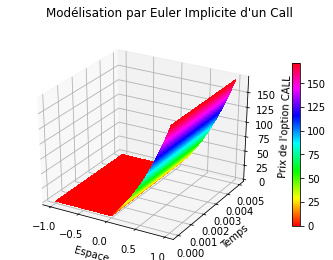

In [ ]:
# plot 3D : 

X2,TAU2 = np.meshgrid(x,tau)
fig2 = plt.figure()
ax2 = fig2.gca(projection = '3d')
surf2 = ax2.plot_surface(X2,TAU2,call_EI, rstride=1, cstride=1, cmap='hsv', linewidth=0, antialiased=False)
fig2.colorbar(surf2, shrink=0.75, aspect=20)
fig2.suptitle("Modélisation par Euler Implicite d'un Call")
ax2.set_xlabel("Espace")
ax2.set_ylabel("Temps")
ax2.set_zlabel("Prix de l'option CALL")
plt.show()


On obtient un graphique très similaire à celui de la solution exacte, ainsi que du Schéma Explicite traité précédemment. De plus, les valeurs sont cohérentes, on peut alors s'avancer sur le fait que notre schéma Euler Implicite est opérationnel.

##Crank-Nicolson

In [ ]:
def Crank_Nicolson(gamma,M,N,x,tau):
    u = np.zeros((M+1,2*N+1))
    
    # Initialisation à tau=0
    for j in range(0,2*N+1):
      u[0,j] = u_0_call(x[j])
        
    # conditions aux bords d'un call
    u[1:M+1,0] = 0     
    for j in range(1,M+1):
      u[j,2*N] = (np.exp(x[2*N]) - np.exp(-r*(T-tau[j]))) * np.exp(-alpha * x[2*N] - beta * tau[j])
    li = decomposition_LU(gamma,N)[0]
    ui = decomposition_LU(gamma,N)[1]  
    b = np.linspace(0,0,2*N-1)
    y = np.linspace(0,0,2*N-1)   
    for j in range(1,M+1):
      b[0] = (1-gamma)*u[j-1,1]+1/2*gamma*u[j-1,N]+1/2*gamma*u[j,0]
      y[0] = b[0]

      for i in range(1,2*N-1): #algorithme de descente
          b[i]=(1 - gamma)*u[j-1,i-1] + 1/2 * gamma *( u[j-1,i-2] + u[j-1,i] )
          y[i] = b[i] - li[i-1]*y[i-1]
      y[2*N-2] = b[2*N-2]+li[2*N-2]*y[2*N-3]
      u[j,2*N-1] = y[-1]/ui[-1]

      for i in range(2*N-2,0,-1): ##algorithme de montee
          u[j,i] = (y[i-1] + gamma*u[j,i+1])/ui[i-1]
    return(u)

In [ ]:
t_imp_0 = time.time()
u_CN = Crank_Nicolson(gamma,M,N,x,tau)
call_CN = u_to_call(u_CN,M,N,x,tau)
t_imp_1 = time.time()
t=t_imp_1-t_imp_0
print("temps d'execution de Crank Nicolson : ",t)

In [ ]:
# plot 3D : 
X2,TAU2 = np.meshgrid(x,tau)
fig2 = plt.figure()
ax2 = fig2.gca(projection = '3d')
surf2 = ax2.plot_surface(X2,TAU2,call_CN, rstride=1, cstride=1, cmap='hsv', linewidth=0, antialiased=False)
fig2.colorbar(surf2, shrink=0.75, aspect=20)
fig2.suptitle("Modélisation par Crank-Nicolson d'un Call")
ax2.set_xlabel("Espace")
ax2.set_ylabel("Temps")
ax2.set_zlabel("Prix de l'option CALL")
plt.show()

# Comparaison des schémas


Le schéma de Crank-Nicolson permet de gagner un ordre en temps.

On constate que les trois schémas ont le même coût de calcul: $ \sigma(N)$ avec N le nombre points.

En temps de  calcul, nous avons remarqué que Euleur est le plus lent , puis Implicite et ensuite CN le plus rapide

Crank-Nicolson est en orde 2 en temps donc permet de gagner un ordre en temps ce qui implique qu'il est plus rapide que les deux autres shemas car on a besoin de moins de points. Parmi les theta-schemas qu'on a testé, on trouve que avec $ \theta=1/2$ c'est-à-dire Crank-Nicolson est le meilleur.


